In [37]:
import requests
from config import API_KEY
import pandas as pd
import numpy as np
import yfinance as yf

## Get Data from eia API

In [2]:
url_gas_prices = f"http://api.eia.gov/series/?api_key={API_KEY}&series_id=PET.EMM_EPMRR_PTE_YORD_DPG.W"
url_WTI = f"http://api.eia.gov/series/?api_key={API_KEY}&series_id=PET.RWTC.W"

In [3]:
df_gas_prices = pd.DataFrame(requests.get(url_gas_prices).json()['series'][0]['data'])

In [4]:
df_WTI = pd.DataFrame(requests.get(url_WTI).json()['series'][0]['data'])

In [5]:
df_WTI.rename(columns = {0:"week", 1:"WTI_price"}, inplace = True)
df_WTI

,week,WTI_price
0,20201030,37.32
1,20201023,40.43
2,20201016,40.33
3,20201009,40.19
4,20201002,38.99
...,...,...
1813,19860131,19.69
1814,19860124,20.31
1815,19860117,24.57
1816,19860110,25.99


In [6]:
df_gas_prices.rename(columns = {0:"week", 1:"gas_price"}, inplace = True)
df_gas_prices

,week,gas_price
0,20201109,2.237
1,20201102,2.223
2,20201026,2.249
3,20201019,2.233
4,20201012,2.267
...,...,...
1062,20000703,1.786
1063,20000626,1.989
1064,20000619,2.108
1065,20000612,2.091


In [7]:
df_gas_prices['week'] = pd.to_datetime(df_gas_prices['week'])
df_WTI['week'] = pd.to_datetime(df_WTI['week'])

In [8]:
df_gas_prices = df_gas_prices.groupby(pd.Grouper(key="week", freq = 'W')).sum()

In [9]:
df_WTI = df_WTI.groupby(pd.Grouper(key="week", freq = 'W')).sum()

In [10]:
df = df_gas_prices.merge(df_WTI, on = 'week')

In [11]:
df

,gas_price,WTI_price
week,,
2000-06-11,1.949,29.79
2000-06-18,2.091,32.45
2000-06-25,2.108,33.55
2000-07-02,1.989,32.12
2000-07-09,1.786,30.40
...,...,...
2020-10-04,2.309,38.99
2020-10-11,2.301,40.19
2020-10-18,2.267,40.33


<AxesSubplot:xlabel='week'>

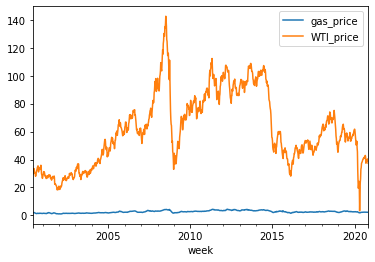

In [12]:
df.plot()

In [13]:
df['gas_change'] = df['gas_price'].diff()
df['WTI_change'] = df['WTI_price'].diff()

In [14]:
df.dropna(inplace =True)

<AxesSubplot:xlabel='week'>

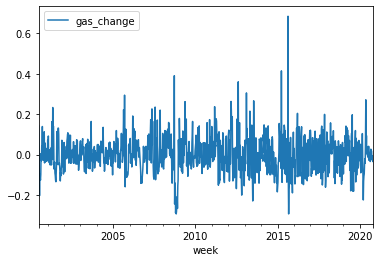

In [15]:
df[['gas_change']].plot()

<AxesSubplot:xlabel='week'>

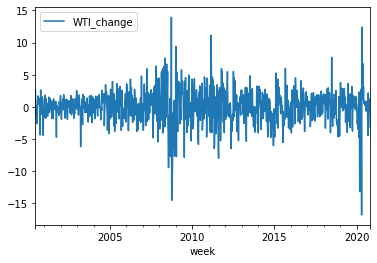

In [16]:
df[['WTI_change']].plot()

## Processs the data

In [17]:
#train test split
train_size = int(0.8 * len(df))
df_train = df.iloc[0:train_size]
df_test = df.iloc[train_size:]

In [18]:
df_train

,gas_price,WTI_price,gas_change,WTI_change
week,,,,
2000-06-18,2.091,32.45,0.142,2.66
2000-06-25,2.108,33.55,0.017,1.10
2000-07-02,1.989,32.12,-0.119,-1.43
2000-07-09,1.786,30.40,-0.203,-1.72
2000-07-16,1.688,30.44,-0.098,0.04
...,...,...,...,...
2016-09-04,2.433,45.11,0.077,-1.94
2016-09-11,2.313,45.96,-0.120,0.85
2016-09-18,2.367,44.34,0.054,-1.62


In [19]:
df_test

,gas_price,WTI_price,gas_change,WTI_change
week,,,,
2016-10-09,2.363,49.48,0.043,2.93
2016-10-16,2.420,50.29,0.057,0.81
2016-10-23,2.291,50.56,-0.129,0.27
2016-10-30,2.274,49.36,-0.017,-1.20
2016-11-06,2.172,45.51,-0.102,-3.85
...,...,...,...,...
2020-10-04,2.309,38.99,-0.007,-0.79
2020-10-11,2.301,40.19,-0.008,1.20
2020-10-18,2.267,40.33,-0.034,0.14


In [20]:
#function for making windows
def make_windows(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [21]:
time_steps = 20
X_train, y_train = make_windows(df_train[['gas_change', 'WTI_change']], df_train['gas_change'], time_steps)
X_test, y_test = make_windows(df_test[['gas_change', 'WTI_change']], df_test['gas_change'], time_steps)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(831, 20, 2) (831,) (193, 20, 2) (193,)


## Build Model

In [22]:
from tensorflow import keras

C:\Users\mpira\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\mpira\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\mpira\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\mpira\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [23]:
model = keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    keras.layers.LSTM(units = 64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    keras.layers.LSTM(units = 32, input_shape=(X_train.shape[1], 64), return_sequences=False),
    # Shape => [batch, time, features]
    keras.layers.Dense(units=1)
])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [24]:
model.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

In [25]:
history = model.fit(
    X_train, y_train,
    epochs=35,
    verbose=1,
    shuffle=False
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/35
831/831 [==============================] - 1s 2ms/sample - loss: 0.0080
Epoch 2/35
831/831 [==============================] - 0s 578us/sample - loss: 0.0077
Epoch 3/35
831/831 [==============================] - 0s 596us/sample - loss: 0.0079
Epoch 4/35
831/831 [==============================] - 1s 618us/sample - loss: 0.0080
Epoch 5/35
831/831 [==============================] - 1s 614us/sample - loss: 0.0072
Epoch 6/35
831/831 [==============================] - 1s 605us/sample - loss: 0.0070
Epoch 7/35
831/831 [==============================] - 1s 642us/sample - loss: 0.0068
Epoch 8/35
831/831 [==============================] - 1s 631us/sample - loss: 0.0067
Epoch 9/35
831/831 [==============================] - 1s 616us/sample - loss: 0.0067
Epoch 10/35
831/831 [==============================] - 0s 588us/sample - loss: 0.0066
Epoch 11/35
831/831 [==============================] - 1s

In [26]:
y_pred = model.predict(X_test)

In [27]:
import matplotlib.pyplot as plt

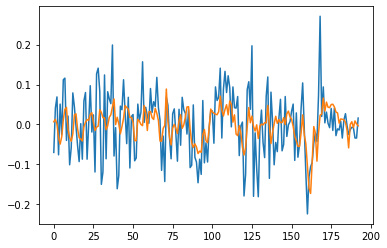

In [28]:
fig, ax = plt.subplots()
ax.plot(y_test)
ax.plot(y_pred)

In [29]:
y_err = np.abs(y_test.reshape(len(df_test) - time_steps,1) - y_pred)

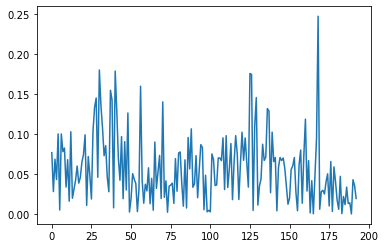

In [30]:
plt.plot(y_err)

In [31]:
np.sum(y_err)/len(y_test)

0.056784539073073535

In [32]:
df_test.reset_index( inplace = True)

In [33]:
intial_price = df_test['gas_price'].iloc[10]

In [34]:
price_pred = [ intial_price + np.sum(y_pred[1:n]) for n in range(1,len(df_test)) ]

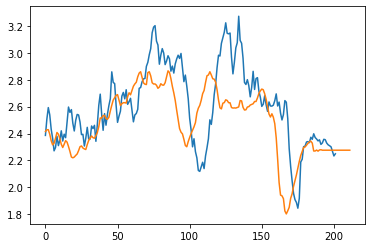

In [35]:
fig, ax = plt.subplots()
ax.plot(df_test['gas_price'].to_list()[11:])
ax.plot(price_pred)